# SVM with Fisher kernel

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import mixture
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report
from tensorflow.keras.datasets import cifar10
import pandas as pd

In [2]:
# Load the CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [3]:
# Select two classes (e.g., class 0 and class 1) and take 250 samples from each
class_0_idx = np.where(y_train == 0)[0][:250]
class_1_idx = np.where(y_train == 1)[0][:250]

In [4]:
# Concatenate the indices and select the samples
selected_idx = np.concatenate((class_0_idx, class_1_idx))
X_subset = X_train[selected_idx]
y_subset = y_train[selected_idx]

In [5]:
# Flatten the images and normalize the pixel values
X_subset_flat = X_subset.reshape(X_subset.shape[0], -1).astype('float32') / 255.0

In [6]:
# Split the data into training and test sets (80% training, 20% test)
X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(X_subset_flat, y_subset, test_size=0.2, random_state=42)

In [30]:
# Fisher vector and Fisher kernel
def fisher_vector_simple(x, gmm):
    means1 = gmm.means_[0]
    means2 = gmm.means_[1]

    cov_inv1 = np.linalg.inv(gmm.covariances_[0])
    cov_inv2 = np.linalg.inv(gmm.covariances_[1])

    score1 = 0
    score2 = 0

    for i in range(3):
        posteriori = gmm.predict_proba(x[:,i].reshape(1, -1))
        diff1 = cov_inv1 @ (x[:,i] - means1)
        diff2 = cov_inv2 @ (x[:,i] - means2)
        score1 += posteriori[0][0] * diff1
        score2 += posteriori[0][1] * diff2
    
    return np.hstack((score1, score2)) 

def fisher_kernel_matrix_simple(X1, X2):
    X1 = X1.reshape(X1.shape[0], 32*32, 3)
    X2 = X2.reshape(X2.shape[0], 32*32, 3)

    F1 = np.array([fisher_vector_simple(x, gmm) for x in X1])
    F2 = np.array([fisher_vector_simple(x, gmm) for x in X2])
    
    gram_matrix = np.dot(F1, F2.T)

    K_diag_1 = np.diag(np.dot(F1, F1.T))
    K_diag_2 = np.diag(np.dot(F2, F2.T))
    
    gram_matrix_normalized =  gram_matrix / np.sqrt(np.outer(K_diag_1, K_diag_2))
            
    return gram_matrix_normalized

In [11]:
# Train a GMM on the training data
gmm = mixture.GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm.fit(X_train_subset.reshape(1200, 1024))

C:\Users\joann\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


GaussianMixture(n_components=2, random_state=42)

In [31]:
# Custom SVC class to use the KL kernel with parameter A
class CustomSVCFisher_v2(SVC):
    def __init__(self, C=5, **kwargs):
        super().__init__(C=C, probability=True, **kwargs)
    
    def fit(self, X, y):
        y = y.ravel()
        self._X_fit = X
        self._gram_matrix_fit = fisher_kernel_matrix_simple(X, X)
        return super().fit(self._gram_matrix_fit, y)
    
    def predict(self, X):
        gram_matrix_test = fisher_kernel_matrix_simple(X, self._X_fit)
        return super().predict(gram_matrix_test)
    
    def predict_proba(self, X):
        gram_matrix_test = fisher_kernel_matrix_simple(X, self._X_fit)
        return super().predict_proba(gram_matrix_test)

# Parameter grid for GridSearchCV
param_grid_Fv2 = {'C': [0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]}  # Regularization parameter for SVC

# Initialize GridSearchCV with custom SVC
grid_search_Fv2 = GridSearchCV(CustomSVCFisher_v2(kernel='precomputed'), param_grid_Fv2, refit=True, verbose=2, cv=5)

# Fit GridSearchCV
grid_search_Fv2.fit(X_train_subset, y_train_subset)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ............................................C=0.005; total time= 6.9min
[CV] END ............................................C=0.005; total time= 7.0min
[CV] END ............................................C=0.005; total time= 7.0min
[CV] END ............................................C=0.005; total time= 6.7min
[CV] END ............................................C=0.005; total time= 7.0min
[CV] END .............................................C=0.01; total time= 7.1min
[CV] END .............................................C=0.01; total time= 7.0min
[CV] END .............................................C=0.01; total time= 7.2min
[CV] END .............................................C=0.01; total time= 7.2min
[CV] END .............................................C=0.01; total time= 7.0min
[CV] END .............................................C=0.05; total time= 6.7min
[CV] END ........................................

GridSearchCV(cv=5, estimator=CustomSVCFisher_v2(),
             param_grid={'C': [0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]},
             verbose=2)

Best parameters found:  {'C': 5}
Accuracy: 0.67
Precision: 0.6768430574400723
Recall: 0.6574074074074074
F1 Score: 0.6547756041426928
ROC AUC: 0.7097423510466989


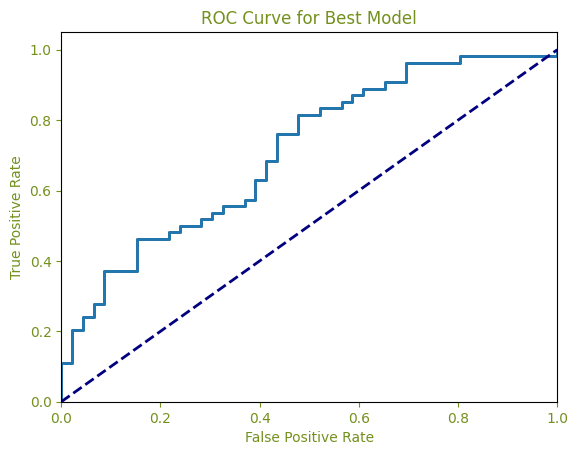

In [32]:
# Get the best parameters
best_params = grid_search_Fv2.best_params_
print("Best parameters found: ", best_params)

# Evaluate the best model
best_model = grid_search_Fv2.best_estimator_
y_pred = best_model.predict(X_test_subset)
y_pred_proba = best_model.predict_proba(X_test_subset) if hasattr(best_model, "predict_proba") else None

# Calculate metrics
accuracy = accuracy_score(y_test_subset, y_pred)
precision = precision_score(y_test_subset, y_pred, average='macro')
recall = recall_score(y_test_subset, y_pred, average='macro')
f1 = f1_score(y_test_subset, y_pred, average='macro')
roc_auc = roc_auc_score(y_test_subset, y_pred_proba[:, 1]) if y_pred_proba is not None else "Not Applicable"

# Print metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")

# Plot ROC curve if probabilities are available
if y_pred_proba is not None:
    positive_class_probabilities = y_pred_proba[:, 1]
    fpr, tpr, _ = roc_curve(y_test_subset.ravel(), positive_class_probabilities)
    plt.plot(fpr, tpr, lw=2, color='#4c5454')
    plt.plot(fpr, tpr, lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', color='#74901d')
    plt.ylabel('True Positive Rate', color='#74901d')
    plt.title('ROC Curve for Best Model', color='#74901d')
    plt.tick_params(colors='#74901d')
    plt.show()

In [35]:
classification_report(y_test_subset, y_pred)

'              precision    recall  f1-score   support\n\n           0       0.70      0.50      0.58        46\n           1       0.66      0.81      0.73        54\n\n    accuracy                           0.67       100\n   macro avg       0.68      0.66      0.65       100\nweighted avg       0.68      0.67      0.66       100\n'